In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from pytz import timezone
from datetime import datetime
import os

In [2]:
# Transform 정의
transform = transforms.Compose(
    [transforms.Resize((224, 224)),  # 바로 224x224로 크기 조정
     transforms.ToTensor(),  # 텐서로 변환
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # 정규화
)

# 배치 크기 및 num_workers 설정
batch_size = 64
num_workers = 4

# CIFAR10 데이터셋 로드
train_dataset = datasets.CIFAR10(
    root='data', train=True, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)

test_dataset = datasets.CIFAR10(
    root='data', train=False, download=True, transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

print(f"Train loader size: {len(train_loader)} batches")
print(f"Test loader size: {len(test_loader)} batches")

100%|██████████| 170M/170M [00:05<00:00, 33.1MB/s]


Extracting data/cifar-10-python.tar.gz to data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Files already downloaded and verified
Train loader size: 782 batches
Test loader size: 157 batches


In [3]:
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}

class VGG(nn.Module):
    def __init__(self,param,in_ = 3, num_classes = 10):
        super(VGG, self).__init__()
        self.param = param
        self.in_ = in_
        self.num_classes = num_classes

        self.conv = self.create_layer(VGG_types[param])
        self.fcs = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.conv(x)  # 컨볼루션 및 풀링 계층 통과
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fcs(x)  # Fully connected 계층 통과
        return x

    def create_layer(self,param):
        layers = []
        in_ = self.in_

        for x in param:
            if type(x) == int:
                out_ = x
                layers += [nn.Conv2d(in_channels=in_, out_channels=out_, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_ = x

            elif x== 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2))]

        return nn.Sequential(*layers)

    def model_summary(self):
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Model: {self.param}, Total Parameters: {total_params:,}")


In [4]:
# 모델, 손실 함수, 옵티마이저 정의
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VGG("VGG11").to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
from tqdm import tqdm

def train_one_epoch(model, train_loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0
    pbar = tqdm(train_loader, desc="Training", leave=False)  # tqdm으로 ProgressBar 추가

    for X, y_true in pbar:
        X, y_true = X.to(device), y_true.to(device)

        # Mixed precision training
        optimizer.zero_grad()

        y_pred = model(X)
        loss = criterion(y_pred, y_true)



        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        pbar.set_postfix({"Batch Loss": loss.item()})  # tqdm의 진행 상태 업데이트

    return running_loss / len(train_loader.dataset)

In [6]:
def validate_one_epoch(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y_true in valid_loader:
            X, y_true = X.to(device), y_true.to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y_true)
            running_loss += loss.item() * X.size(0)

            # Accuracy 계산
            _, predicted = torch.max(y_pred, 1)
            total += y_true.size(0)
            correct += (predicted == y_true).sum().item()

    # 반환값 추가
    epoch_loss = running_loss / len(valid_loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

In [7]:
def fit(model, train_loader, valid_loader, criterion, optimizer, device, epochs=10, use_amp=False):
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    best_val_loss = float('inf')
    train_losses = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Training step
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation step
        val_loss, val_accuracy = validate_one_epoch(model, valid_loader, criterion, device)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Saved Best Model at Epoch {epoch+1}")

        # Logging
        print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    return train_losses, valid_losses, valid_accuracies

In [8]:
train_losses, valid_losses, valid_accuracies = fit(model, train_loader, test_loader, criterion, optimizer, device, 10)


Epoch 1/10


Saved Best Model at Epoch 1
Train Loss: 2.2702, Val Loss: 1.8775, Val Accuracy: 0.3124

Epoch 2/10


Saved Best Model at Epoch 2
Train Loss: 1.8621, Val Loss: 1.7161, Val Accuracy: 0.3419

Epoch 3/10


Saved Best Model at Epoch 3
Train Loss: 1.6935, Val Loss: 1.4724, Val Accuracy: 0.4496

Epoch 4/10


Saved Best Model at Epoch 4
Train Loss: 1.4286, Val Loss: 1.2409, Val Accuracy: 0.5703

Epoch 5/10


Saved Best Model at Epoch 5
Train Loss: 1.1571, Val Loss: 0.9982, Val Accuracy: 0.6702

Epoch 6/10


Saved Best Model at Epoch 6
Train Loss: 0.9836, Val Loss: 0.9358, Val Accuracy: 0.6838

Epoch 7/10


Saved Best Model at Epoch 7
Train Loss: 0.8506, Val Loss: 0.7554, Val Accuracy: 0.7385

Epoch 8/10


Saved Best Model at Epoch 8
Train Loss: 0.7289, Val Loss: 0.6723, Val Accuracy: 0.7749

Epoch 9/10


Train Loss: 0.6332, Val Loss: 0.6732, Val Accuracy: 0.7706

Epoch 10/10


Saved Best Model at Epoch 10
Train Loss: 0.5536, Val Loss: 0.5666, Val Accuracy: 0.8101


True: cat, Predicted: cat


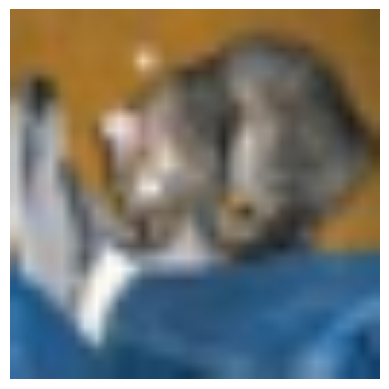

True: ship, Predicted: ship


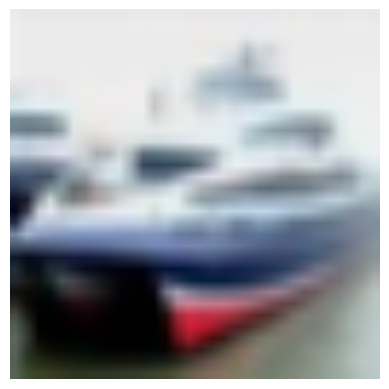

True: ship, Predicted: ship


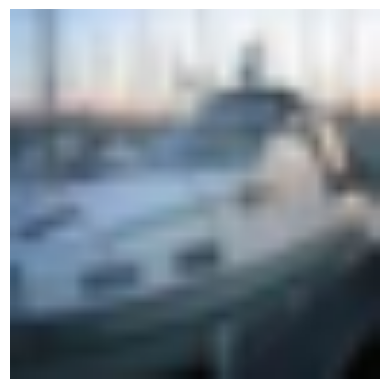

True: plane, Predicted: plane


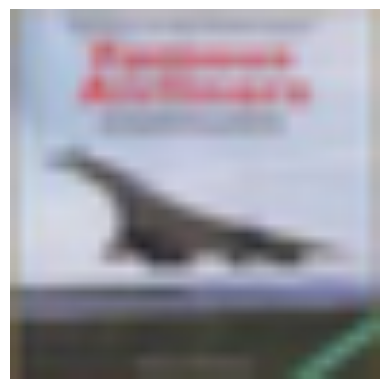

True: frog, Predicted: frog


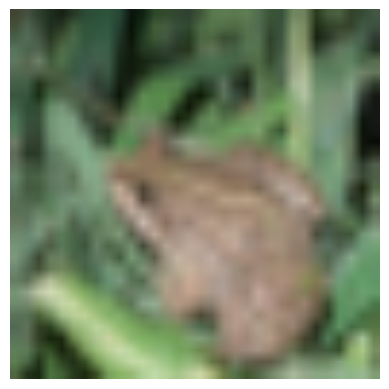

In [9]:
# CIFAR-10 클래스 이름
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # 정규화 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# 테스트 샘플 확인
def show_test_results(model, test_loader, device, num_samples=5):
    model.eval()
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    # 모델 예측
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # 시각화
    for i in range(num_samples):
        print(f"True: {classes[labels[i]]}, Predicted: {classes[predicted[i]]}")
        imshow(images[i].cpu())  # 이미지 시각화

# 예제 실행
show_test_results(model, test_loader, device, num_samples=5)

True: cat, Predicted: cat


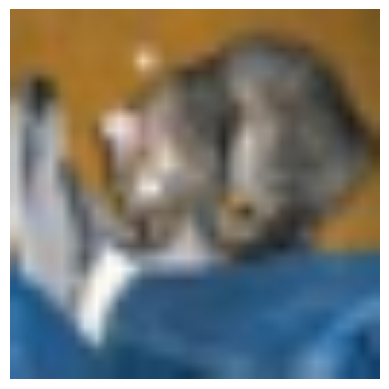

True: ship, Predicted: ship


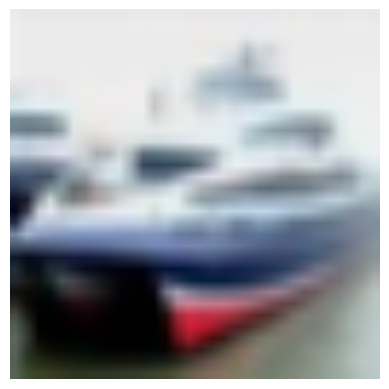

True: ship, Predicted: ship


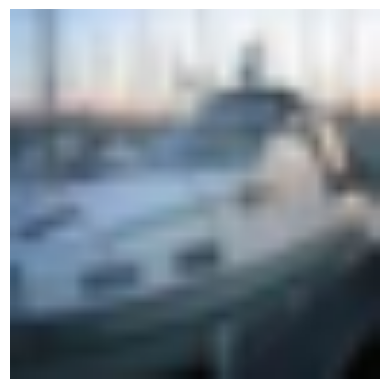

True: plane, Predicted: plane


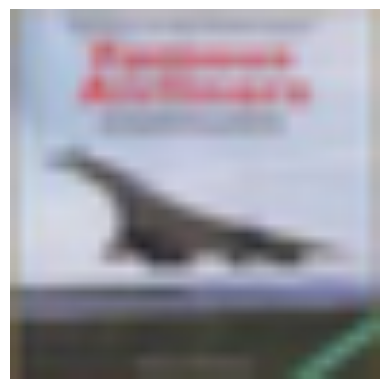

True: frog, Predicted: frog


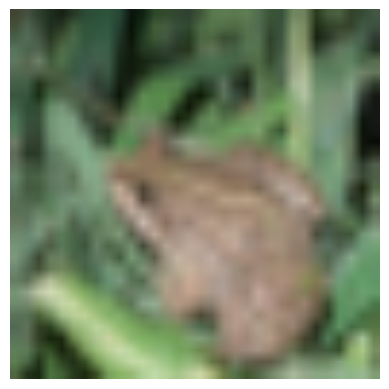

True: frog, Predicted: frog


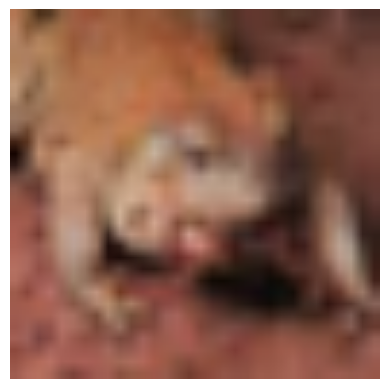

True: car, Predicted: car


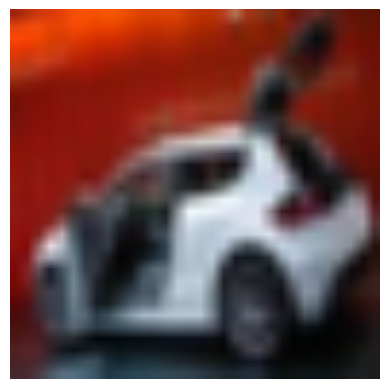

True: frog, Predicted: frog


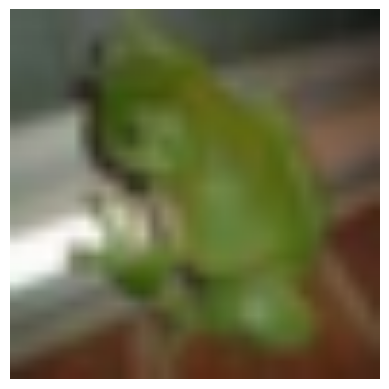

True: cat, Predicted: cat


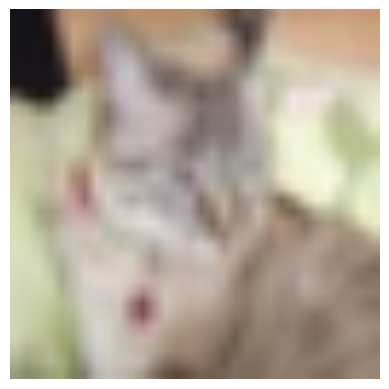

True: car, Predicted: car


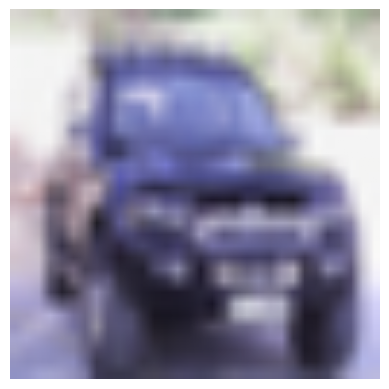

True: plane, Predicted: plane


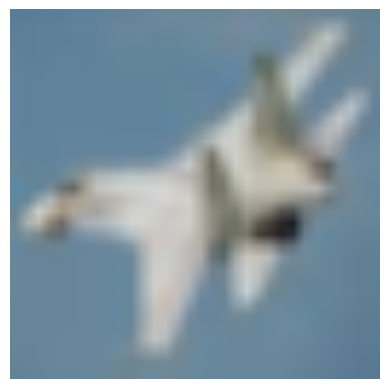

True: truck, Predicted: truck


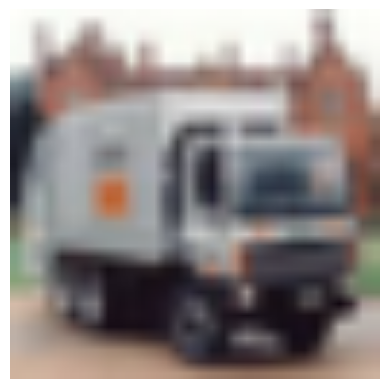

True: dog, Predicted: dog


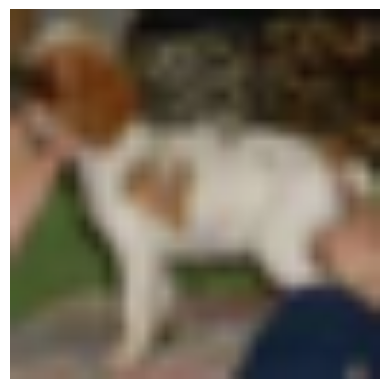

True: horse, Predicted: horse


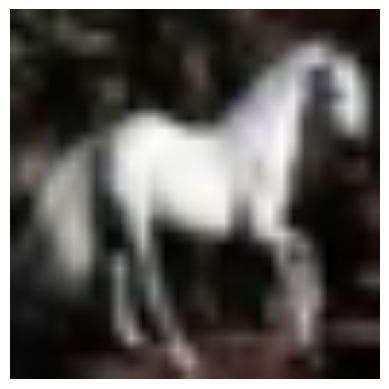

True: truck, Predicted: truck


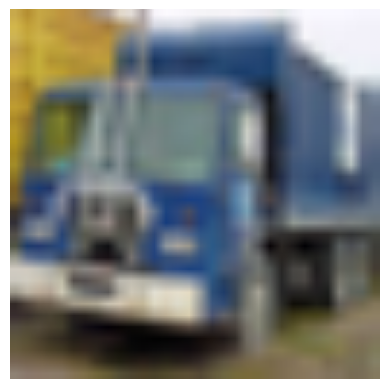

In [11]:
# 예제 실행
show_test_results(model, test_loader, device, num_samples=15)

In [12]:
def show_incorrect_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    incorrect_images = []
    incorrect_labels = []
    incorrect_predictions = []

    # 테스트 데이터 순회
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # 잘못 예측된 샘플 찾기
            for img, label, pred in zip(images, labels, predicted):
                if label != pred:
                    incorrect_images.append(img.cpu())
                    incorrect_labels.append(label.cpu())
                    incorrect_predictions.append(pred.cpu())

                if len(incorrect_images) >= num_samples:  # 지정된 개수만큼 저장
                    break
            if len(incorrect_images) >= num_samples:
                break

    # 잘못된 예측 시각화
    for i in range(len(incorrect_images)):
        print(f"True: {classes[incorrect_labels[i]]}, Predicted: {classes[incorrect_predictions[i]]}")
        imshow(incorrect_images[i])

True: dog, Predicted: deer


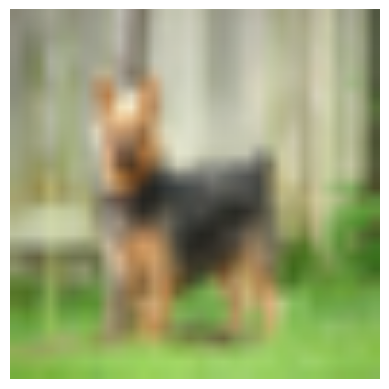

True: deer, Predicted: bird


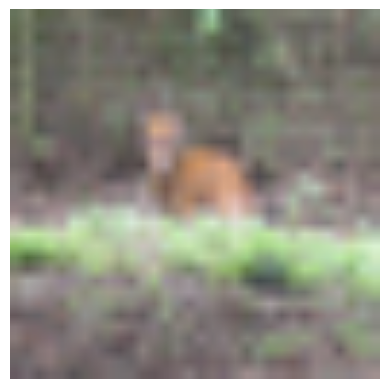

True: bird, Predicted: ship


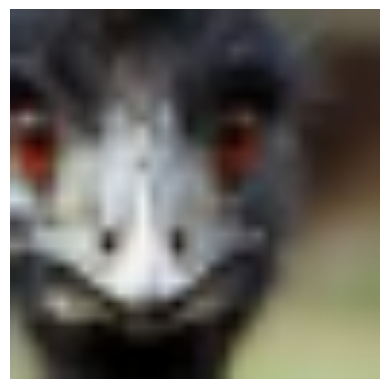

True: car, Predicted: truck


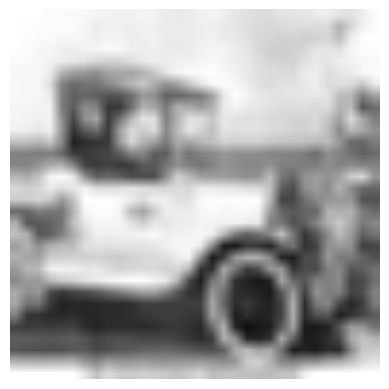

True: frog, Predicted: bird


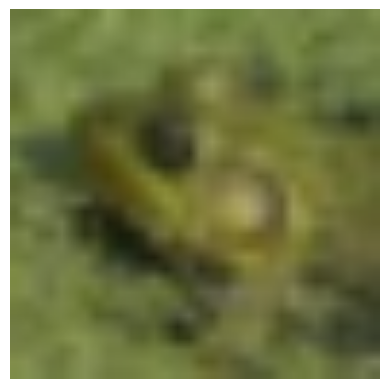

True: plane, Predicted: horse


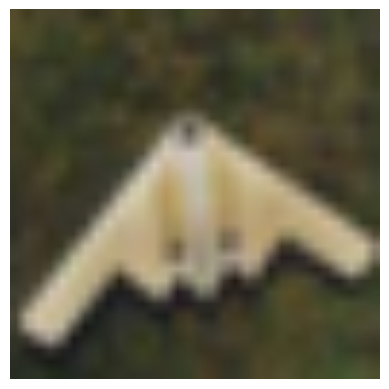

True: deer, Predicted: cat


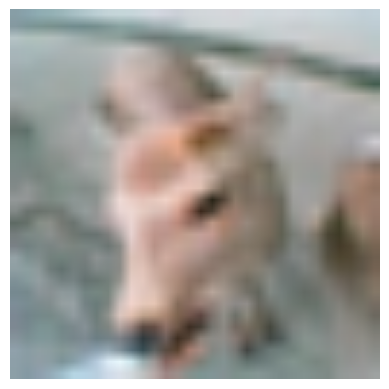

True: frog, Predicted: dog


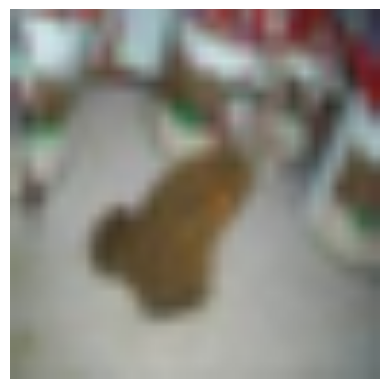

True: cat, Predicted: dog


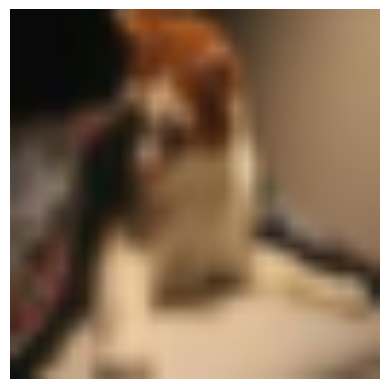

True: bird, Predicted: frog


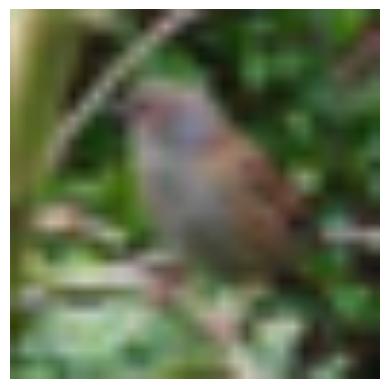

True: bird, Predicted: plane


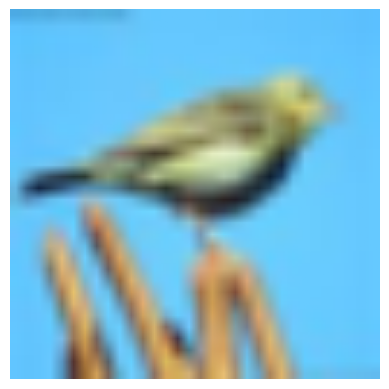

True: cat, Predicted: dog


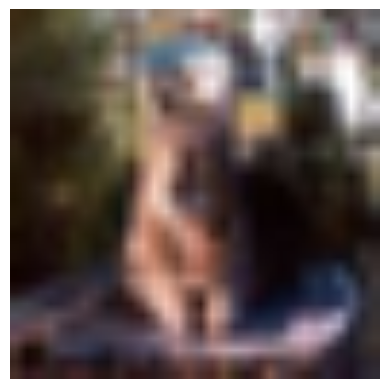

True: horse, Predicted: truck


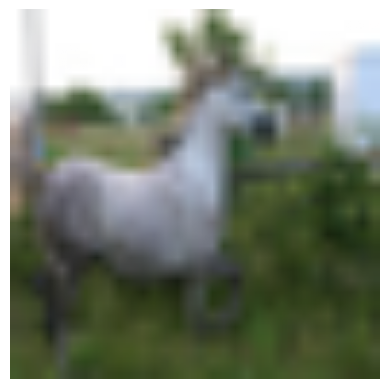

True: truck, Predicted: plane


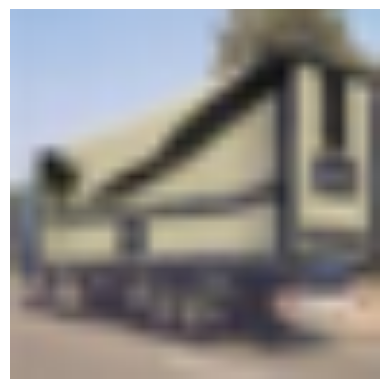

True: cat, Predicted: dog


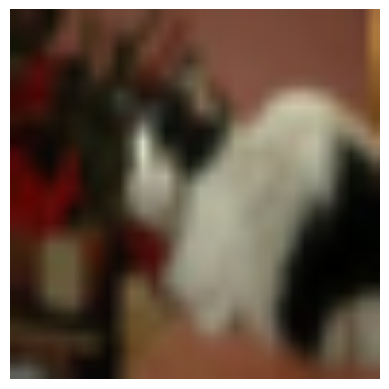

In [14]:
# 잘못 예측된 이미지 확인
show_incorrect_predictions(model, test_loader, device, num_samples=15)